## Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [13]:
testing_file = testing_files["Xiaomeng"]
AMOUNT_OF_SENSORS = 2

## Datapreparation

#### Train

In [3]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    knn_train.append(elem)

y_train = pd.concat([x.df['Pose'] for x in knn_train])

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Test


In [14]:
knn_test = df_wrapper(testing_file.csv_file)
knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
knn_test.align_poses(testing_file.annot_file, POSE_MAP)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \


## Visualisation

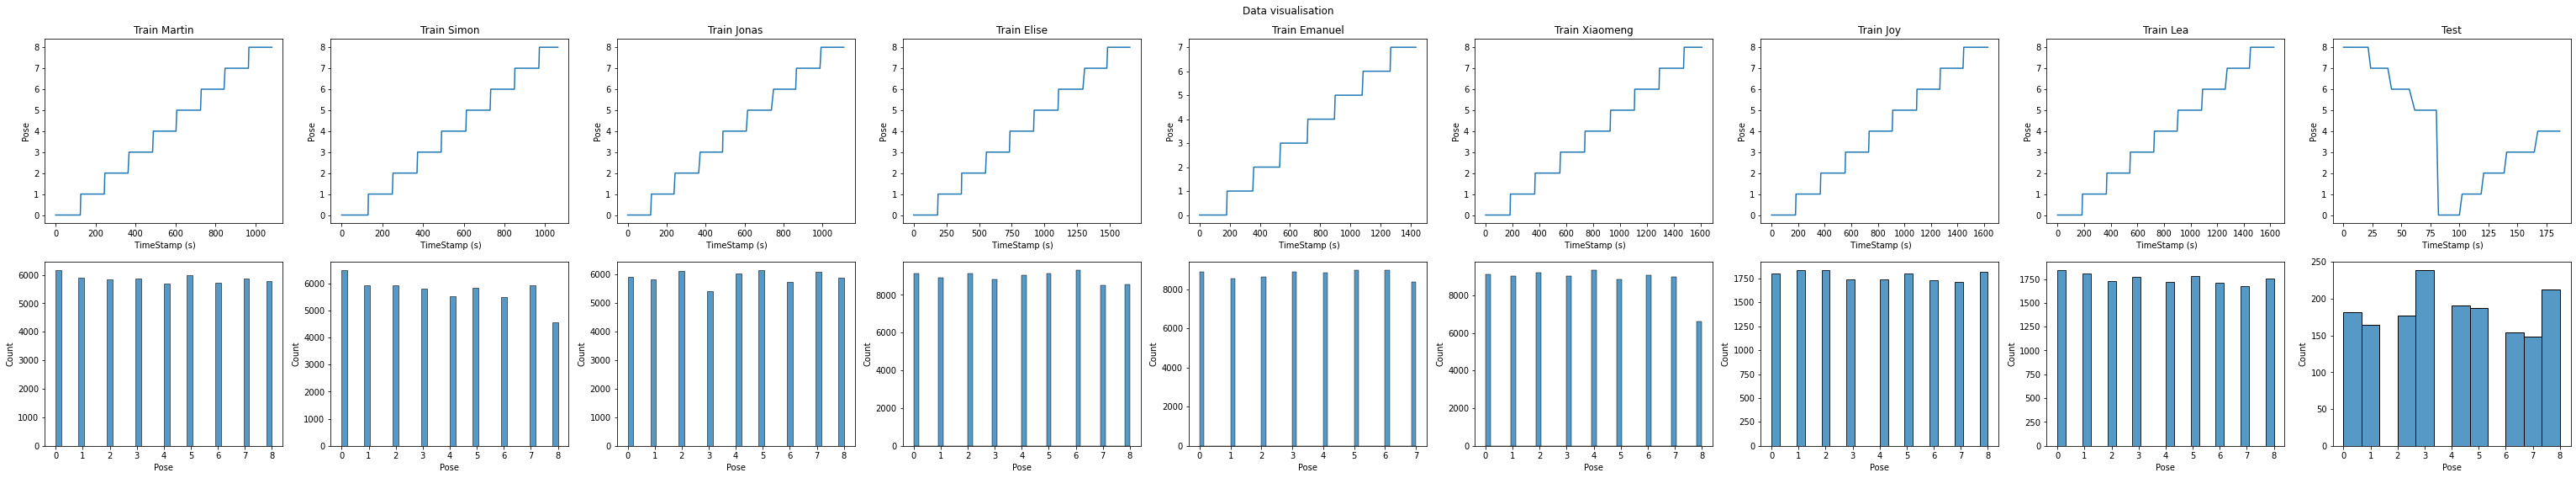

In [5]:
cols = []
height=8
width=(height/1.5)*len(knn_train)
fig, axes = plt.subplots(2, len(knn_train)+1, figsize=(width, height))
fig.suptitle('Data visualisation')
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append('Train')    
for i, key in enumerate(training_files):
    cols[i] += f' {key}'
sns.lineplot(ax=axes[0, len(knn_train)], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, len(knn_train)], data=y_test)
cols.append('Test')
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [15]:
x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(419125, 26)
(419125,)
(8367, 26)
(8367,)


### GridSearch

In [7]:
"""
n_estimators_lst = [i for i in range(75, 125)]
parameters = {'n_estimators':n_estimators_lst} 
rfc = RandomForestClassifier(random_state=69)
clf = GridSearchCV(rfc, parameters, n_jobs=-1)
clf.fit(x_train, y_train)
"""

"\nn_estimators_lst = [i for i in range(75, 125)]\nparameters = {'n_estimators':n_estimators_lst} \nrfc = RandomForestClassifier(random_state=69)\nclf = GridSearchCV(rfc, parameters, n_jobs=-1)\nclf.fit(x_train, y_train)\n"

## RFC            

In [16]:
pipe = make_pipeline(RandomForestClassifier(n_estimators=150, random_state=42))
pipe.fit(x_train,y_train)
predictions = pipe.predict(x_test)

## Precision

In [17]:
number_of_corrects = 0
for num in range(len(predictions)):
    if(predictions[num] == y_test.iloc[num]):
        number_of_corrects += 1

print(f"Prediction accuracy: {round(number_of_corrects/len(predictions)*100,2)}%")

Prediction accuracy: 96.2%


## Visualization


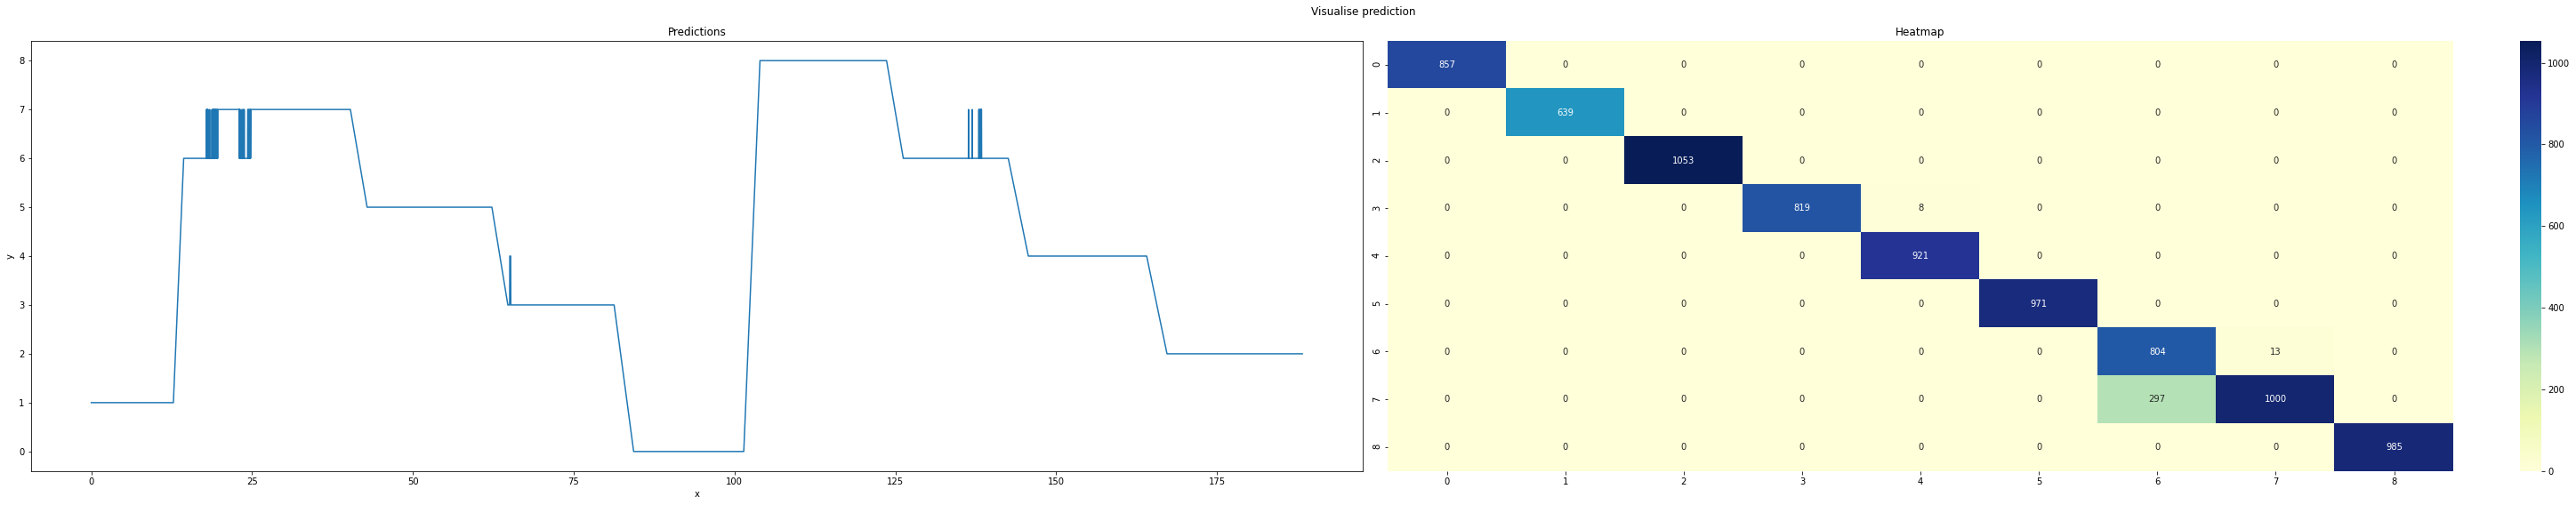

In [18]:
df_predict = pd.DataFrame({'x': knn_test.df[' TimeStamp (s)'],'y':predictions})

fig, axes = plt.subplots(1, 2, figsize=(width, height))
sns.lineplot(ax=axes[0], data=df_predict,x='x',y='y')
sns.heatmap(ax=axes[1], data=confusion_matrix(y_test, predictions), 
            cmap="YlGnBu", annot=True, fmt="d")
fig.suptitle('Visualise prediction')
cols = ['Predictions', 'Heatmap']
for ax, col in zip(axes, cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Classification matrix and report

In [19]:
#print(confusion_matrix(y_test, predictions))
#print(classification_report(y_test, predictions, zero_division=True))

In [20]:
from joblib import dump, load
dump(pipe, f'../models/RFC_model_{AMOUNT_OF_SENSORS}.joblib')

['../models/RFC_model_2.joblib']

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>